# <span style ='color: red'>  Author: Nikolin Prenga </span>

# <span style ='color: darkblue'>  Date Created: May 10, 2024 </span>

# <span style ='color: green'>Description: This hypermodel, implemented in Python, optimizes and redesigns the LeNet-5 architecture through parameter tuning. </span>

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import cv2
from Image_Data_Preprocessing import Image_Processing as Process_Images
import time
import keras_tuner as kt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
home_dir_train ='MRI_Training/'
home_dir_test ='MRI_Testing/'

training_data_MRI, training_labels_MRI, training_text_MRI = Process_Images(home_dir_train).load_data_and_crop_Optionally()
X_test_hyper_MRI, y_test_hyper_MRI, y_text_hyper_MRI = Process_Images(home_dir_test).load_data_and_crop_Optionally()

In [3]:
Process_Images(home_dir_train).Check_size_shape()

Total number of samples analyzed: 5712
Number of non-square images (different width and height): 1218
Number of square images smaller than 250x250 pixels: 354
Number of square images sized between 250x250 and 299x299 pixels: 26
Number of square images sized between 300x300 and 399x399 pixels: 13
Number of square images sized between 400x400 and 499x499 pixels: 41
Number of square images sized between 500x500 and 599x599 pixels: 3960
Number of square images larger than or equal to 600x600 pixels: 100


In [4]:
Process_Images(home_dir_test).Check_size_shape()

Total number of samples analyzed: 1311
Number of non-square images (different width and height): 390
Number of square images smaller than 250x250 pixels: 99
Number of square images sized between 250x250 and 299x299 pixels: 5
Number of square images sized between 300x300 and 399x399 pixels: 2
Number of square images sized between 400x400 and 499x499 pixels: 10
Number of square images sized between 500x500 and 599x599 pixels: 790
Number of square images larger than or equal to 600x600 pixels: 15


In [5]:
# ### Split the training dataset into training and validation sets

X_train_hyper_MRI, X_val_hyper_MRI, y_train_hyper_MRI, y_val_hyper_MRI = train_test_split(training_data_MRI, training_labels_MRI,
                                                              test_size=0.12, random_state=42)

In [6]:
print(f'Training dataset shape for MRI images: {X_train_hyper_MRI.shape}')
print(f'Validation dataset shape for MRI images: {X_val_hyper_MRI.shape}\n')

print(f'Training labels shape for MRI images: {y_train_hyper_MRI.shape}')
print(f'Validation labels shape for MRI images: {y_val_hyper_MRI.shape}')

Training dataset shape for MRI images: (5026, 250, 250)
Validation dataset shape for MRI images: (686, 250, 250)

Training labels shape for MRI images: (5026,)
Validation labels shape for MRI images: (686,)


In [7]:
# Class names
class_names = {
    0: "No Tumor",
    1: "Glioma Tumor",
    2: "Meningioma Tumor",
    3: "Pituitary Tumor"
}

In [8]:
class LeNet5_HyperModel(kt.HyperModel):

    def __init__(self,
                 train_data,
                 val_data,
                 test_data,
                 train_label,
                 val_label,
                 test_label):

        self.train_label= train_label
        self.val_label=val_label
        self.test_label=test_label

        # Check if the data is grayscale (i.e., only has height and width, but no channel dimension)
        # If so, add an additional dimension to make it compatible with TensorFlow's channel requirement

        if len(train_data.shape)==3:
            self.train_data = np.expand_dims(train_data, axis=-1)
            self.val_data = np.expand_dims(val_data, axis=-1)
            self.test_data = test_data = np.expand_dims(test_data, axis=-1)
        # If the data already includes a channel dimension or more, use it as is

        else:
            self.train_data = train_data
            self.val_data=val_data
            self.test_data = test_data

        # Initialize early stopping callback to monitor training and prevent overfitting
        self.early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.000,
        patience=15,
        verbose=0,
        mode='min',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0)
        # Initialize the Final_Model attribute to None before assignment
        self.Final_Model = None

        ## Reduce learning rate when a metric has stopped improving.
        #self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001, verbose=1)

        self.epochs =50

    def build(self, hp):
        ############################################################################################################################
        input_image_shape=tf.keras.Input(shape=self.train_data.shape[1:])#keras.Input(240, 240, 1)
        #input_tensor = tf.keras.Input(shape=(240, 240, 1))
        print(input_image_shape)

        Conv1 = tf.keras.layers.Conv2D(filters=hp.Int('1st ConvNet Filters', min_value=24, max_value =40, step=2) ,
                                        kernel_size=hp.Int('1st ConvNet Kernel Size', min_value=3, max_value= 9, step=2),
                                       strides=hp.Int('Stride Conv1', min_value=1, max_value=4, step=1),
                                       activation= 'relu' )(input_image_shape)
        # hp.Choice('First Convolution', values =['relu',  'selu','elu', 'gelu', 'LeakyReLU', 'silu']
        ##############################################################################################################################

        Pool1 =tf.keras.layers.MaxPooling2D( pool_size=hp.Int('Pool1_Kernel_Size', min_value=2, max_value= 6, step=1),
                                            strides=hp.Int('Pool1_Stride', min_value=2, max_value=5, step=1))(Conv1)
        #################################################################################################################################

        Conv2 = tf.keras.layers.Conv2D(filters=hp.Int('2sd ConvNet Filters', min_value=24, max_value =74, step=4),
                                       kernel_size=hp.Int('2nd ConvNet Kernel Size',  min_value=3, max_value= 9, step=2),
                                       strides=hp.Int('Stride Conv2', min_value=1, max_value=4, step=1),
                                       activation='relu')(Pool1)
        # hp.Choice('Second Convolution', values =['relu', 'selu','elu', 'gelu', 'LeakyReLU', 'silu'] )

        #################################################################################################################################


        Pool2 = tf.keras.layers.MaxPooling2D( pool_size=hp.Int('Pool2_Kernel_Size', min_value=2, max_value= 5, step=1),
                                             strides=hp.Int('Pool2_Stride', min_value=2, max_value=4, step=1))(Conv2)



        ################################################################################################################################

        Flatten = tf.keras.layers.Flatten()(Pool2)

        ##################################################################################################################################

        Dense_layer1 =tf.keras.layers.Dense(units=hp.Int('Neurons in 1st layer', min_value= 30, max_value = 540, step=20),
                                             activation='relu' )(Flatten)
        # hp.Choice('1st Dense Layer Act', values =['relu',  'selu','elu', 'gelu', 'LeakyReLU', 'silu'] )
        #################################################################################################################################

        Dropout_1 = tf.keras.layers.Dropout(rate= hp.Choice('First Dropout', values =[0.0, 0.1, 0.2, 0.3, 0.4]))(Dense_layer1)
        #################################################################################################################################

        Dense_layer2 = tf.keras.layers.Dense(units= hp.Int('Neurons in 2sd layer', min_value= 30, max_value = 540, step=20) ,
                                             activation= 'relu')(Dropout_1)
        # hp.Choice('2st Dense Layer Act', values =['relu',  'selu','elu', 'gelu', 'LeakyReLU', 'silu'] )
        ##################################################################################################################################
        Dropout_2 = tf.keras.layers.Dropout(rate= hp.Choice('Second Dropout', values =[0.0, 0.1, 0.2, 0.3, 0.4]))(Dense_layer2)
        #################################################################################################################################

        output = tf.keras.layers.Dense(units=4, activation='softmax')(Dropout_2)
        ##################################################################################################################################

        Optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= hp.Choice('Learning_rates', values=[0.01,  0.005, 0.001,  0.0005]))
        #Optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0007)


        # hp_optimizer = hp.Choice('Optimizer', values=['SGD', 'Adam',   'Adagrad'])
        # #learnings = [0.1, 0.07, 0.03, 0.01,  0.007, 0.005, 0.001, 0.0007, 0.0005]

        # if hp_optimizer=='SGD':
        #     hp_learning_SGD = hp.Choice ('learning_rate_SGD', values=[0.1,  0.05, 0.01,  0.005, 0.001])
        #     Optimizer = tf.keras.optimizers.legacy.SGD(learning_rate= hp_learning_SGD)

        # elif hp_optimizer =='Adam':
        #     hp_learning_adam = hp.Choice ('learning_rate_Adam', values=[0.1,  0.05, 0.01,  0.005, 0.001])
        #     Optimizer=  tf.keras.optimizers.legacy.Adam(learning_rate= hp_learning_adam )

        # elif hp_optimizer=='Adagrad':
        #     hp_learning_Adagrad = hp.Choice ('learning_rate_Adagrad', values=[0.1,  0.05, 0.01,  0.005, 0.001])
        #     Optimizer = tf.keras.optimizers.legacy.Adagrad(learning_rate= hp_learning_Adagrad)

        #########################################################################################################
        #create a Model by specifying its inputs and outputs in the graph of layers
        #########################################################################################################

        self.model = tf.keras.Model(inputs=input_image_shape, outputs=output, name="HyperModel")

        #Compile the model
        self.model.compile(optimizer =  Optimizer,
                           loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])
        return self.model

    #########################################################################################################
    #########################################################################################################
    ## Configure and execute hyperparameter tuning using the Hyperband optimization algorithm

    #########################################################################################################
    #########################################################################################################
    def Tune_HyperModel(self):
        # Initialize and configure the Hyperband tuner for hyperparameter optimization using Keras Tuner.
        # Objective is to maximize validation accuracy over a maximum of Y epochs, with a reduction factor of YY.
        # The tuner will explore different configurations, storing results in 'My_Directory' under project 'Parameter_Directory'.
        # The search process involves training the model for up to X epochs with early stopping and validation data.
        tuner =None
        
        try:
            tuner = kt.Hyperband(self.build,
                     objective='val_accuracy',
                     max_epochs=60,
                     factor= 3,
                     directory ='Directory_Parameters_Batchos',
                     project_name='Hyperparameters_Batchos')
            # Execute the search to find the best model parameters based on the training and validation datasets.
            tuner.search(self.train_data, self.train_label, epochs=30, callbacks = [self.early_stopping],
                        validation_data = (self.val_data, self.val_label))
        except Exception as e:
            print("An error occurred while setting up the Hyperband tuner:", str(e))


        return tuner


    def Choose_Optimal_Model(self):

        # Obtain a tuner object by tuning the hypermodel once
        tuner = self.Tune_HyperModel()

        # Get the best hyperparameters from the tuning session
        best_parameters = tuner.get_best_hyperparameters(num_trials=1)[0]

        # Build the model with the best hyperparameters found
        model_hyperparameters = tuner.hypermodel.build(best_parameters)

        self.history_hypermarameter = model_hyperparameters.fit(self.train_data, self.train_label,
                                                                    epochs = self.epochs,
                                                                    callbacks= [self.early_stopping],
                                                                    validation_data = [self.val_data, self.val_label])
        # Identify the epoch number with the highest validation accuracy from the training history
        best_accuracy_per_epoch = self.history_hypermarameter.history['val_accuracy']
        best_epoch = best_accuracy_per_epoch.index(max(best_accuracy_per_epoch)) + 1

        # Train the model using the number of epochs that yielded the best validation accuracy
        model_best_epoch = self.Tune_HyperModel().hypermodel.build(best_parameters)
        model_best_epoch.fit(self.train_data, self.train_label,
                             callbacks= [self.early_stopping],
                             epochs = best_epoch,
                            validation_data = [self.val_data, self.val_label])

        # Retrieve the accuracies for two models:
        # one trained across all epochs and another trained up to the epoch with the best validation accuracy
        ACC_model_hyperparameter = model_hyperparameters.evaluate(self.test_data, self.test_label)[1]
        ACC_best_epoch = model_best_epoch.evaluate(self.test_data, self.test_label)[1]


        # Select the model with the highest validation accuracy
        if ACC_model_hyperparameter >= ACC_best_epoch:

            print(f'Hypermodel trained over all epochs is chosen with accuracy: {np.round(ACC_model_hyperparameter, 3)},'
                  f'over model trained up to the best epoch (Accuracy: {np.round(ACC_best_epoch, 3)}).\n')
            

            # print(f'Hypermodel trained over all epochs is chosen with accuracy: {np.round(ACC_model_hyperparameter, 3)},'
            #       f'over model trained up to the best epoch (Accuracy: {np.round(ACC_best_epoch, 3)}).\n')
            self.Final_Model = model_hyperparameters
        else:
            print(f'Model trained up to the best epoch (Accuracy: {np.round(ACC_best_epoch,3)}) is chosen over'
                  f'hypermodel trained over all epochs (Accuracy: {np.round(ACC_model_hyperparameter, 3)}).')
            self.Final_Model = model_best_epoch

        return self.Final_Model





    #######################################################################################################################

    def Plot_History(self):
        max_epoxs = len(self.history_hypermarameter.history['val_accuracy'])+1
        x_epochs= np.arange(1, max_epoxs)

        accuracy_train = self.history_hypermarameter.history['accuracy']
        accuracy_train = [x*100 for x in accuracy_train ]
        accuracy_val  = self.history_hypermarameter.history['val_accuracy']
        accuracy_val = [y*100 for y in accuracy_val ]
        # print(len(accuracy_train))
        # print(len(accuracy_val))
        # print(len(x_epochs))


        plt.figure(figsize=(14,6))
        plt.subplot(1,2,1)
        plt.plot(x_epochs, accuracy_train, marker='o', lw=3,  color='red', label ='Training Accuracy'  )
        plt.plot(x_epochs, accuracy_val, marker ='s', lw=3, color='blue', label='Validation Accuracy' )
        plt.grid()
        plt.xlabel('Epochs', color ='deeppink', fontsize=15)
        plt.ylabel('Accuracy (%)', color ='deeppink', fontsize=15)
        plt.title('Accuracy Over Epochs for Training and Validation Datasets', color='green',fontsize=15)
        plt.legend(fontsize=14)

        ###################################################################################################################
        #
        loss_train = self.history_hypermarameter.history['loss']
        loss_val = self.history_hypermarameter.history['val_loss']
        plt.subplot(1,2,2)
        plt.plot(x_epochs, loss_train, marker='o', lw=3,  color='magenta', label ='Training Loss'  )
        plt.plot(x_epochs, loss_val, marker ='s', lw=3, color='darkblue', label='Validation Loss' )
        plt.grid()
        plt.xlabel('Epochs', color ='darkred', fontsize=15)
        plt.ylabel('Loss', color ='maroon', fontsize=15)
        plt.title('Loss Over Epochs for Training and Validation Datasets', color='r',fontsize=15)
        plt.legend(fontsize=14)
        plt.tight_layout()
        plt.show()
        ##############################################################


    def Evaluate_model(self):
        self.Final_Model.summary()
        probabilities = self.Final_Model.predict(self.test_data)
        predicted_labels = np.argmax(probabilities, axis=1)

        print('Printing Confution Matrix')
        target_names = [class_names[label] for label in range(4) ]
        cm = confusion_matrix(self.test_label, predicted_labels)
        disp_base = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp_base.plot()
        plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
        plt.show()

        print('Printing Classification Report \n')
        print(classification_report(self.test_label  ,predicted_labels, target_names=target_names))
        return probabilities
    
    def predict_Tumor_Type(self, image):
        # Ensure the image is correctly preprocessed for the model input if needed
        if len(image.shape)==2:
            self.image = np.expand_dims(image, -1)

        else:
            self.image = image

        # Get the prediction probabilities from the model
        pred_prob = self.Final_Model.predict(np.expand_dims(self.image, axis=0))[0]  
        # Find the index of the highest probability which corresponds to the predicted tumor type
        pred_tumortype = np.argmax(pred_prob)

        # Printing the confidence and the tumor type with correct rounding and string formatting
        print('\n')
        print(f'We are {np.round(pred_prob[pred_tumortype] * 100, 2)}% confident that this image is {class_names[pred_tumortype]}.')

        # Plotting the image with prediction
        plt.subplot(1, 2, 1)
        plt.imshow(self.image, cmap='binary')
        plt.xlabel("Model's Prediction on Image")
        plt.title(f'Model Predicted: {class_names[pred_tumortype]}')

        # Plotting the bar chart of tumor type probabilities
        plt.subplot(1, 2, 2)
        labels = [class_names[label] for label in range(len(pred_prob))]
        val_probs = [pred_prob[x] for x in range(len(pred_prob))]

        bars = plt.bar(labels, val_probs, color='darkgreen', width=0.4)

        # Rotate the labels to prevent overlap
        plt.xticks(rotation=45)

        # Adding text labels above the bars
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, f'{np.round(yval * 100, 2)}%', ha='center', va='bottom')

        plt.xlabel("Tumor Types")
        plt.ylabel("Probability")
        plt.title("Probability Distribution \n Across Tumor Types")

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()

    def Get_Best_Parameters(self):

        best_parameters = self.Tune_HyperModel().get_best_hyperparameters(num_trials=1)[0]
        print('Convolutional Layers')
        print('The most optimal number of filters in the first ConvNet is: {}'.format(best_parameters.get('1st ConvNet Filters')))
        print('The most optimal number of filters in the second ConvNet is: {}'.format(best_parameters.get('2sd ConvNet Filters')))

        print('The most optimal kernel size in the 1st ConvNet layer is {} (squared) '.format(best_parameters.get('1st ConvNet Kernel Size')))
        print('The most optimal kernel size in the 2nd ConvNet layer is {} (squared) '.format(best_parameters.get('2nd ConvNet Kernel Size')))
        print('\n')
        print('The most optimal stride in the 1st ConvNet layer is {} (squared) '.format(best_parameters.get('Stride Conv1')))
        print('The most optimal stride in the 2nd ConvNet layer is  {} (squared) '.format(best_parameters.get('Stride Conv2')))
        print('\n')
        print('Pooling Layers')
        print('The most optimal kernel size for first pooling found is: {} (squared)'.format(best_parameters.get('Pool1_Kernel_Size')))
        print('The most optimal kernel size for the second pooling is: {} (squared) '.format(best_parameters.get('Pool2_Kernel_Size')))

        print('The most optimal number of strides on first pooling found is is: {} (squared)'.format(best_parameters.get('Pool1_Stride')))
        print('The most optimal number of strides on second pooling found is: {} (squared)'.format(best_parameters.get('Pool2_Stride')))
        print('\n')
        print('Dense Layers')

        print('The most optimal number of neurons in the first layer are: {} (squared)'.format(best_parameters.get('Neurons in 1st layer')))
        print('The most optimal number of neurons in the second layer are: {} (squared)'.format(best_parameters.get('Neurons in 2sd layer')))
        print('\n')
        print('Dropout Rate in between layers')

        print('The best dropout rate between the first and second hidden layers is: {}'.format(best_parameters.get('First Dropout')))
        print('The best dropout rate between the second hidden layer and the output layer is: {}'.format(best_parameters.get('Second Dropout')))

        print('Most optimal learning rate cosen by the hypermodel is: {}'.format(best_parameters.get('Learning_rates')))


In [9]:
Hyper = LeNet5_HyperModel(X_train_hyper_MRI, X_val_hyper_MRI, X_test_hyper_MRI, y_train_hyper_MRI, y_val_hyper_MRI, y_test_hyper_MRI) 


In [10]:
Hyper.Tune_HyperModel()

Reloading Tuner from Directory_Parameters_Batchos/Hyperparameters_Batchos/tuner0.json


In [11]:
Hyper.Choose_Optimal_Model()

Reloading Tuner from Directory_Parameters_Batchos/Hyperparameters_Batchos/tuner0.json
KerasTensor(type_spec=TensorSpec(shape=(None, 250, 250, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Epoch 1/50
158/158 [==============================] - 24s 152ms/step - loss: 4.3875 - accuracy: 0.5573 - val_loss: 0.6463 - val_accuracy: 0.7609
Epoch 2/50
158/158 [==============================] - 24s 152ms/step - loss: 0.6355 - accuracy: 0.7537 - val_loss: 0.5022 - val_accuracy: 0.8207
Epoch 3/50
158/158 [==============================] - 24s 151ms/step - loss: 0.4881 - accuracy: 0.8183 - val_loss: 0.4422 - val_accuracy: 0.8397
Epoch 4/50
158/158 [==============================] - 24s 154ms/step - loss: 0.3442 - accuracy: 0.8737 - val_loss: 0.3937 - val_accuracy: 0.8499
Epoch 5/50
158/158 [==============================] - 24s 151ms/step - loss: 0.2659 - accuracy: 0.9021 - val_loss: 0.3343 - val_accuracy: 0.8688
Epoch 6/50
158/158 [================

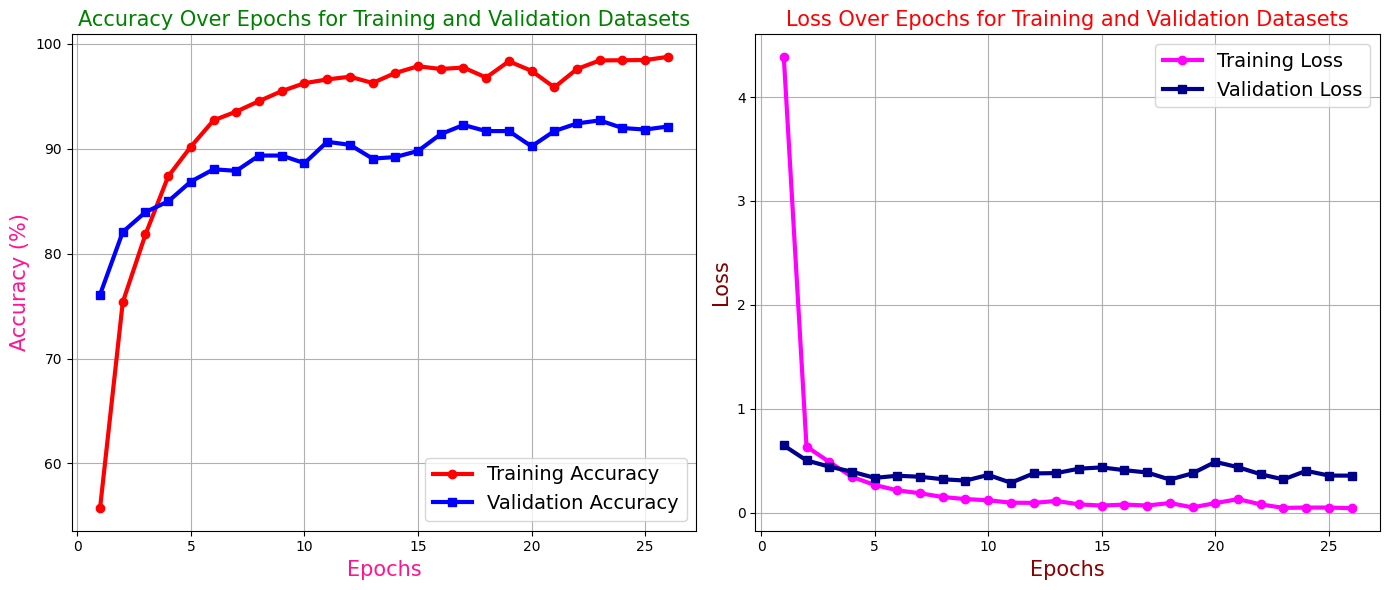

In [12]:
Hyper.Plot_History()

Model: "HyperModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 248, 248, 26)      260       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 26)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 68)        15980     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 68)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 15300)             0

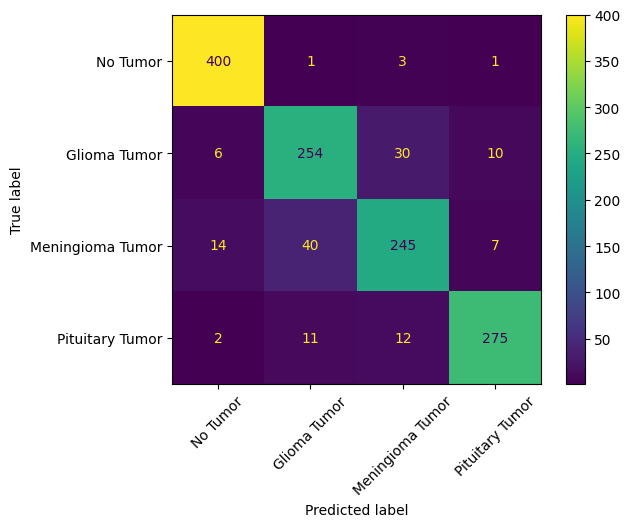

Printing Classification Report 

                  precision    recall  f1-score   support

        No Tumor       0.95      0.99      0.97       405
    Glioma Tumor       0.83      0.85      0.84       300
Meningioma Tumor       0.84      0.80      0.82       306
 Pituitary Tumor       0.94      0.92      0.93       300

        accuracy                           0.90      1311
       macro avg       0.89      0.89      0.89      1311
    weighted avg       0.89      0.90      0.89      1311



In [13]:
_ =Hyper.Evaluate_model()

1/1 [==============================] - 0s 16ms/step


We are 100.0% confident that this image is No Tumor.


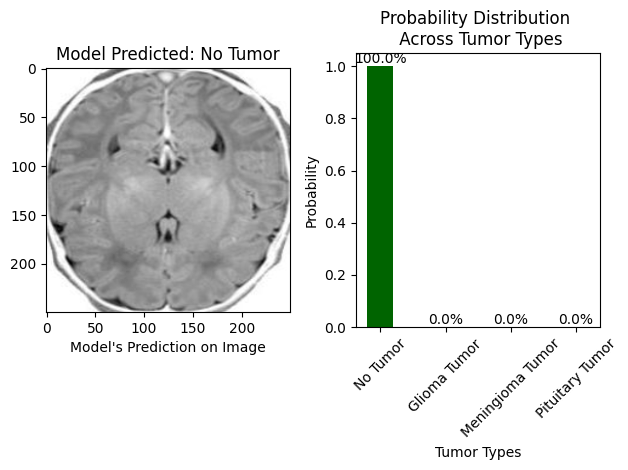

The actual image is: No Tumor
_______________________________________________________________________________ 

1/1 [==============================] - 0s 13ms/step


We are 99.99% confident that this image is No Tumor.


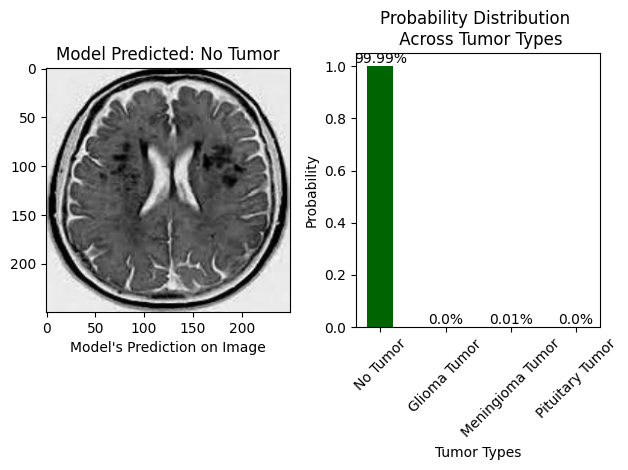

The actual image is: No Tumor
_______________________________________________________________________________ 

1/1 [==============================] - 0s 14ms/step


We are 100.0% confident that this image is Meningioma Tumor.


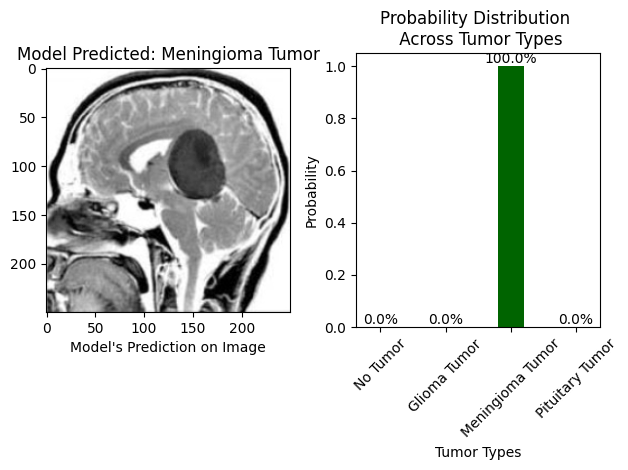

The actual image is: Meningioma Tumor
_______________________________________________________________________________ 

1/1 [==============================] - 0s 14ms/step


We are 99.99% confident that this image is No Tumor.


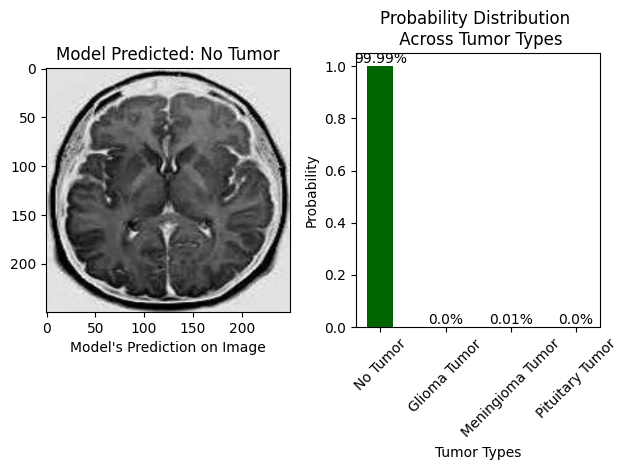

The actual image is: No Tumor
_______________________________________________________________________________ 



In [14]:


for s in range(5, 9):
    Hyper.predict_Tumor_Type(X_test_hyper_MRI[s])
    print(f'The actual image is: {class_names[y_test_hyper_MRI[s]]}')
    print('_______________________________________________________________________________ \n')

In [15]:
Hyper.Get_Best_Parameters()

Reloading Tuner from Directory_Parameters_Batchos/Hyperparameters_Batchos/tuner0.json
Convolutional Layers
The most optimal number of filters in the first ConvNet is: 26
The most optimal number of filters in the second ConvNet is: 68
The most optimal kernel size in the 1st ConvNet layer is 3 (squared) 
The most optimal kernel size in the 2nd ConvNet layer is 3 (squared) 


The most optimal stride in the 1st ConvNet layer is 1 (squared) 
The most optimal stride in the 2nd ConvNet layer is  1 (squared) 


Pooling Layers
The most optimal kernel size for first pooling found is: 3 (squared)
The most optimal kernel size for the second pooling is: 4 (squared) 
The most optimal number of strides on first pooling found is is: 4 (squared)
The most optimal number of strides on second pooling found is: 4 (squared)


Dense Layers
The most optimal number of neurons in the first layer are: 470 (squared)
The most optimal number of neurons in the second layer are: 470 (squared)


Dropout Rate in betwee